In [1]:
# %load_ext autoreload
# %autoreload 2

from IPython.lib.deepreload import reload as dreload
import os
import sys

import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as dt

from skimage import io, measure
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from stackview import orthogonal as imshow
import warnings

warnings.filterwarnings("ignore")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    EarlyStopping,
)

sys.path.append("../../gap/")
from GAP_3DUNET_ResBlock import UN
from BinomDataset import BinomDataset3D
from inference import sample_image

device = torch.device("cuda:0")

# Training

### Loading the data
_________________

We load the data. We can use the full dataset for training, since this is self-supervised and we do not require ground truth.

In [2]:
DIRPATH = "/mnt/d/Yehe/gaptest/"
filePaths = [
    os.path.join(DIRPATH, f) for f in os.listdir(DIRPATH) if f.endswith(".tif")
]
fileNames = [os.path.splitext(os.path.basename(f))[0] for f in filePaths]

dataList = []
channelList = []

# load and frint the information of the data
print(f"{'ID':<4}{'NAME':<24}{'SHAPE':<4}")
for idx, name in enumerate(fileNames):
    data = imread(filePaths[idx])
    if len(data.shape) == 3:
        data = data[:, None, ...]
    data = data.swapaxes(0, 1)
    dataList.append(data)
    channelList.append(data.shape[0])
    print(f"{idx:<3}{name[28:]:<25}{data.shape}")

ID  NAME                    SHAPE
0   405Pwr20                (2, 504, 512, 512)
1   405Pwr50                (2, 504, 512, 512)
2   BlankA                  (2, 504, 512, 512)
3   BlankB                  (2, 504, 512, 512)
4   LineAccu1               (3, 517, 512, 512)


In [ ]:
ID = 6
CHANNEL = 1
NAME = fileNames[ID][28:]
data = dataList[ID][CHANNEL]
imshow(data, 
       colormap="magma", 
       display_max=3,
       )

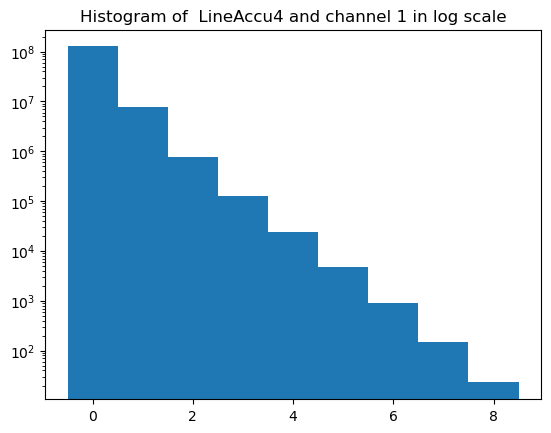

In [ ]:
# plot the histogram of the data in log scale
_ = plt.hist(data.flatten(), bins=np.arange(10) - 0.5, log=True)
plt.title(f"Histogram of {NAME} and channel {CHANNEL} in log scale")
plt.show()

In [ ]:
def psnrToString(inp):
    if inp < 0:
        return "m" + str(-inp)
    else:
        return str(inp)


# we set the pseudo PSNR range used for splitting the images into input and target
unitThickness = 64
windowSize = (64, 64, 64)
WINDOWSIZESTR = "x".join(map(str, windowSize))
minpsnr = -40
maxpsnr = 0
batch_size = 32

name = f"{NAME}_C{CHANNEL}_PSNR{psnrToString(minpsnr)}to{psnrToString(maxpsnr)}_WIN{WINDOWSIZESTR}"
CHECKPOINT_PATH = "./models/"

print(name)

 LineAccu4_C1_PSNRm40to0_WIN64x64x64


In [ ]:
maxepochs = 10000  # train longer for better results

# Create pytorch dataset
dataset = BinomDataset3D(
    data[: round(data.shape[0] * 0.8)],
    unitThickness=unitThickness,
    windowSize=windowSize,
    rand_crop=True,
    minPSNR=minpsnr,
    maxPSNR=maxpsnr,
    virtSize= 500*32
)

val_dataset = BinomDataset3D(
    data[: round(data.shape[0] * 0.8)],
    unitThickness=unitThickness,
    windowSize=windowSize,
    rand_crop=True,
    minPSNR=minpsnr,
    maxPSNR=maxpsnr,
)

# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=12,
)
val_loader = dt.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=False,
    num_workers=12,
)

img = next(iter(val_loader))
print(img.shape)

torch.set_float32_matmul_precision('high')
trainer = pl.Trainer(
    accelerator="gpu",
    devices="auto",
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=0.5,
    max_epochs=maxepochs,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor("epoch"),
        EarlyStopping("val_loss", patience=2000),
    ],
)

model = UN(
    levels=8, 
    channels=1, 
    depth=4, 
    start_filts=32, 
    up_mode="transpose",
)

torch.Size([64, 2, 64, 64, 64])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name) + ".ckpt")

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type       | Params
------------------------------------------
0 | conv_final | Conv3d     | 33    
1 | down_convs | ModuleList | 5.9 M 
2 | up_convs   | ModuleList | 2.1 M 
------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
31.826    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[rank: 1] Received SIGTERM: 15


ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/multiprocessing/spawn.py", line 69, in _wrap
    fn(i, *args)
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 153, in _wrapping_function
    results = function(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 571, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 980, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 1023, in _run_stage
    self.fit_loop.run()
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py", line 202, in run
    self.advance()
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py", line 355, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/training_epoch_loop.py", line 133, in run
    self.advance(data_fetcher)
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/training_epoch_loop.py", line 219, in advance
    batch_output = self.automatic_optimization.run(trainer.optimizers[0], kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/optimization/automatic.py", line 188, in run
    self._optimizer_step(kwargs.get("batch_idx", 0), closure)
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/optimization/automatic.py", line 266, in _optimizer_step
    call._call_lightning_module_hook(
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py", line 146, in _call_lightning_module_hook
    output = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/core/module.py", line 1276, in optimizer_step
    optimizer.step(closure=optimizer_closure)
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py", line 161, in step
    step_output = self._strategy.optimizer_step(self._optimizer, closure, **kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/strategies/ddp.py", line 257, in optimizer_step
    optimizer_output = super().optimizer_step(optimizer, closure, model, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/strategies/strategy.py", line 231, in optimizer_step
    return self.precision_plugin.optimizer_step(optimizer, model=model, closure=closure, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/plugins/precision/precision_plugin.py", line 116, in optimizer_step
    return optimizer.step(closure=closure, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/optim/optimizer.py", line 280, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/optim/optimizer.py", line 33, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/optim/adam.py", line 121, in step
    loss = closure()
           ^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/plugins/precision/precision_plugin.py", line 103, in _wrap_closure
    closure_result = closure()
                     ^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/optimization/automatic.py", line 142, in __call__
    self._result = self.closure(*args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/optimization/automatic.py", line 128, in closure
    step_output = self._step_fn()
                  ^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/loops/optimization/automatic.py", line 315, in _training_step
    training_step_output = call._call_strategy_hook(trainer, "training_step", *kwargs.values())
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py", line 294, in _call_strategy_hook
    output = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/strategies/ddp.py", line 330, in training_step
    return self.model(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/nn/parallel/distributed.py", line 1156, in forward
    output = self._run_ddp_forward(*inputs, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/nn/parallel/distributed.py", line 1110, in _run_ddp_forward
    return module_to_run(*inputs[0], **kwargs[0])  # type: ignore[index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/pytorch_lightning/overrides/base.py", line 90, in forward
    output = self._forward_module.training_step(*inputs, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/users/yehe/Documents/Projects/GAP3D/examples/convallaria/../../gap/GAP_3DUNET_ResBlock.py", line 378, in training_step
    self(batch[:, self.channels :, ...]),  # apply to output of all batch
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/users/yehe/Documents/Projects/GAP3D/examples/convallaria/../../gap/GAP_3DUNET_ResBlock.py", line 317, in forward
    input = module(before_pool, input)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/users/yehe/Documents/Projects/GAP3D/examples/convallaria/../../gap/GAP_3DUNET_ResBlock.py", line 184, in forward
    input = F.relu(self.conv2(input_skip))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yehe/mambaforge/envs/gap3d/lib/python3.11/site-packages/torch/nn/functional.py", line 1457, in relu
    result = torch.relu(input)
             ^^^^^^^^^^^^^^^^^
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 23.99 GiB total capacity; 20.20 GiB already allocated; 282.00 MiB free; 21.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


# Denoising

In [ ]:
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name) + ".ckpt").to("cpu")

In [ ]:
# dataTest = imread('./data/testData.tif')[:1]     # to speed things up, we are only doing the first image
# dataTestGT =imread('./data/testDataGT.tif')[:1]
z, y, x = (180, 0, 0)
z_size = 64
dataTest1 = data[z : z + z_size, x : x + 128, y : y + 128]
# dataTest2 = data[z_size : z_size + z_size, x : x + 512, y : y + 512]
print(data.shape)

imshow(
    dataTest1, colormap="inferno"
)

(517, 512, 512)


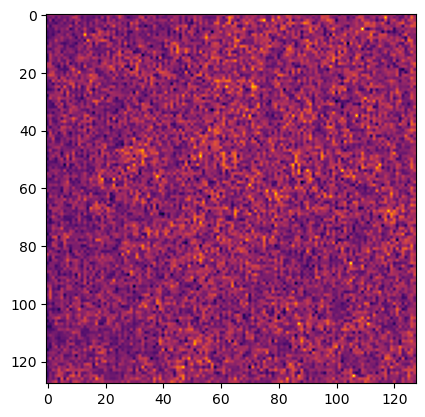

In [ ]:
dataTestB = torch.from_numpy(dataTest1).float()
out = torch.exp(model(dataTestB[None, None, ...]))
out = dataTest1.sum() * out / out.sum()
dataTest1 = out.detach().numpy()[0,0]
del out, dataTestB

# dataTestB = torch.from_numpy(dataTest2).float()
# out = torch.exp(model(dataTestB[None, None, ...]))
# out = dataTest1.sum() * out / out.sum()
# dataTest2 = out.detach().numpy()[0,0]
# del out, dataTestB

plt.imshow(
    dataTest1[30],
    cmap="inferno",
)

# Sampling images

In [ ]:
import matplotlib.image as mpimg
import time
import numpy as np

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 64
pixels_y = 64

inp_img = torch.zeros(batch_size, channels, 64, pixels_y, pixels_x)
print(inp_img.shape)

for i in range(1):
    startTime = time.time()

    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(
        inp_img, 
        model, 
        beta=0.05, 
        save_every_n=10, 
        max_psnr=40,
    )

    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
        #         print(iterations)

        print(denoised.shape)
        plt.figure(figsize=(5, 5))
        plt.imshow(
            denoised[j, 0, [10]].squeeze(),
            cmap="inferno",
            vmin=0,
            vmax=np.percentile(denoised[j], 99.99),
        )
        plt.title("Denoisied")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.imshow(
            photons[j, 0, [10]].squeeze(), 
            cmap="inferno", 
            vmin=0, 
            vmax=np.percentile(photons[j], 99.99),
        )
        plt.title("Photon counts")
        plt.show()

    print("_______________________________________", iterations)

    endTime = time.time()
    elapsedTime = endTime - startTime
    print(
        "time (s):", elapsedTime, "time per image (s)", elapsedTime / denoised.shape[0]
    )

## Looking at the intermediate outputs

In [ ]:
print(stack[2][32, 99, 32])
for i in range(len(stack)):
    im = stack[i]
    # print(i)
    plt.figure(figsize=(12, 12))
    plt.imshow(im[20], cmap="inferno")
    plt.title("left: Photon counts, right: Denoised")
    plt.show()

In [ ]:
data2 = dataset[1].detach().numpy()
plt.imshow(data2[0][32], cmap="inferno")
plt.show()
plt.imshow(data2[1][32], cmap="inferno")
plt.show()

